<h1>Seminar 1: Optimizing Conference Paper </h1>
Assignment Using Genetic Algorithms <div>
Intelligent Systems <div>
October 28,

In [5]:
import numpy as np
%pip install pygad
import pygad
import random
import json
import itertools
import matplotlib.pyplot as plt


Note: you may need to restart the kernel to use updated packages.


Data

In [6]:

with open('datasets/easy_dataset_1.json', 'r') as file:
    data = json.load(file)
num_papers = data['num_papers']
num_reviewers = data['num_reviewers']
reviewer_capacity = data['reviewer_capacity']
min_reviews_per_paper = data['min_reviews_per_paper']
max_reviews_per_paper = data['max_reviews_per_paper']
#print(num_papers, num_reviewers, reviewer_capacity, min_reviews_per_paper, max_reviews_per_paper)

num_generations = 1000
population_size = 500
num_parents_mating = 5
P = np.array(data['preferences'])
F = np.array(data['friendships'])
A = np.array(data['authorship'])

<h3> Print functions </h3>

In [7]:

def print_solution(solution_matrix):
    solution_matrix = solution_matrix.reshape((num_reviewers, num_papers))

    header = "Reviewers\\Papers||| " + " | ".join([f"Paper {i+1}" for i in range(num_papers)])
    print(header)
    print("-" * len(header))

    # Print each reviewer's assignments
    for reviewer_idx in range(num_reviewers):
        row = f"Reviewer {reviewer_idx+1:<6} |||   " + "  |   ".join(f"{value:<4}" for value in solution_matrix[reviewer_idx])
        print(row)


<h2>Task 1 - Representation <h2>
<h3>
 -   Deciding on an effective solution representation. <div>
 -   Designing a fitness function. <div>
 -   Implementing and executing the genetic algorithm. <div>

In [8]:
def solution_is_valid(solution,get_sum=True,print_values=False, return_matrix = False):
    solution = solution.flatten()
    penalty_authorship = 0
    penalty_min_reviews = 0
    penalty_max_reviews = 0
    penalty_reviewer_capacity = 0
    penalty_friends = 0
    penalty_authorship = np.sum(solution * A.flatten())
    reshaped_sol = solution.reshape((num_reviewers, num_papers))
    per_reviewer = np.sum(reshaped_sol, axis=1)
    per_paper = np.sum(reshaped_sol, axis=0)
    penalty_min_reviews = np.sum(per_paper < min_reviews_per_paper)
    penalty_max_reviews = np.sum(per_paper > max_reviews_per_paper)
    penalty_reviewer_capacity = np.sum(per_reviewer > reviewer_capacity)
    co_review_matrix = np.dot(reshaped_sol, reshaped_sol.T)
    friend_review_counts = F * co_review_matrix
    penalty_friends = np.sum(friend_review_counts) // 2
    authored_papers_by_friends = np.dot(F, A)
    penalty_matrix = reshaped_sol * authored_papers_by_friends
   # penalty_friends += np.sum(penalty_matrix)

    if print_values:
        print("penalty_authorship: ", penalty_authorship)
        print("penalty_min_reviews: ", penalty_min_reviews)
        print("penalty_max_reviews: ", penalty_max_reviews)
        print("penalty_reviewer_capacity: ", penalty_reviewer_capacity)
        print("penalty_friends: ", penalty_friends)
        print("Sum: ", penalty_authorship + penalty_min_reviews + penalty_max_reviews + penalty_reviewer_capacity + penalty_friends)

    if return_matrix:
        sol = (penalty_authorship, penalty_min_reviews, penalty_max_reviews, penalty_reviewer_capacity, penalty_friends)
        return np.array(sol)
    if (not get_sum):
        return (penalty_authorship, penalty_min_reviews, penalty_max_reviews, penalty_reviewer_capacity, penalty_friends)
    else:
        return (penalty_authorship + penalty_min_reviews + penalty_max_reviews + penalty_reviewer_capacity + penalty_friends)
  
def initial_population(num_reviewers, num_papers, population_size,num=5):
    best_population = None
    best_count = None
    first = True
    for i in range(num):
        population = np.random.randint(0, 2, size=(population_size, num_reviewers * num_papers))
        count = 0
        for j in range(population_size):
            count += solution_is_valid(population[j], get_sum=True,print_values=False)
        count /= population_size
        if first or count > best_count:
            first = False
            best_count = count
            best_population = population

    print("Best count: ", best_count)
    return population
def create_fitness_function_basic(fitness_penalty):
    def fitness_func_basic(ga_instance, solution, solution_idx):
        preference_score = np.sum(solution * P.flatten())
        penalty = 0
        penalty += np.sum(solution * A.flatten()) * fitness_penalty["authorship"]
        reshaped_sol = solution.reshape((num_reviewers, num_papers))
        per_reviewer = np.sum(reshaped_sol, axis=1)
        per_paper = np.sum(reshaped_sol, axis=0)
        penalty += np.sum(per_paper < min_reviews_per_paper) * fitness_penalty["min_reviews"]
        penalty += np.sum(per_paper > max_reviews_per_paper) * fitness_penalty["max_reviews"]
        penalty += np.sum(per_reviewer > reviewer_capacity) * fitness_penalty["reviewer_capacity"]
        co_review_matrix = np.dot(reshaped_sol, reshaped_sol.T)
        friend_review_counts = F * co_review_matrix
        penalty += np.sum(friend_review_counts) // 2 * fitness_penalty["friends"]

        return preference_score - penalty
    return fitness_func_basic

In [9]:
fitnes_penalty = {
    "friends": 2,
    "authorship": 8,
    "min_reviews": 12,
    "max_reviews": 12,
    "reviewer_capacity": 9
}
initial_pop = initial_population(num_reviewers, num_papers, population_size)

ga_instance = pygad.GA(
    num_generations=num_generations,
    num_parents_mating=num_parents_mating,
    fitness_func=create_fitness_function_basic(fitnes_penalty),
    sol_per_pop=population_size,
    num_genes=num_reviewers * num_papers,
    initial_population=initial_pop,
    crossover_type="single_point",
    mutation_type="random",
    mutation_percent_genes=5,
    gene_type=int,
    gene_space=[0, 1],
    stop_criteria= "saturate_50",
    parent_selection_type="rank",
)


Best count:  7.82


c:\Users\Vid\miniconda3\envs\ls_a01\Lib\site-packages\pygad\pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


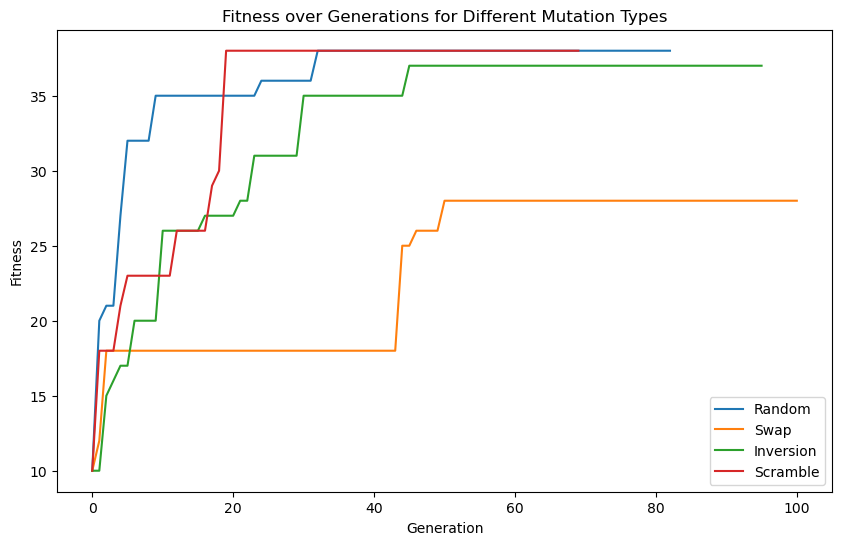

In [10]:
def run_ga_and_plot_fitness(mutation_funcs, mutation_names):
    fitness_history = {name: [] for name in mutation_names}
    
    for mutation_func, name in zip(mutation_funcs, mutation_names):
        ga_instance = pygad.GA(
            num_generations=num_generations,
            num_parents_mating=num_parents_mating,
            fitness_func=create_fitness_function_basic(fitnes_penalty),
            sol_per_pop=population_size,
            num_genes=num_reviewers * num_papers,
            initial_population=initial_pop,
            crossover_type="single_point",
            mutation_type=mutation_func,
            mutation_probability=0.05,
            gene_type=int,
            gene_space=[0, 1],
            stop_criteria="saturate_50",
            parent_selection_type="tournament"
        )
        
        ga_instance.run()
        fitness_history[name] = ga_instance.best_solutions_fitness
        
    # Plot the fitness history
    plt.figure(figsize=(10, 6))
    for name in mutation_names:
        plt.plot(fitness_history[name], label=name)
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.title("Fitness over Generations for Different Mutation Types")
    plt.legend()
    plt.show()


mutation_funcs = ["random", "swap", "inversion","scramble"]	
mutation_names = ["Random", "Swap", "Inversion", "Scramble"]

run_ga_and_plot_fitness(mutation_funcs, mutation_names)

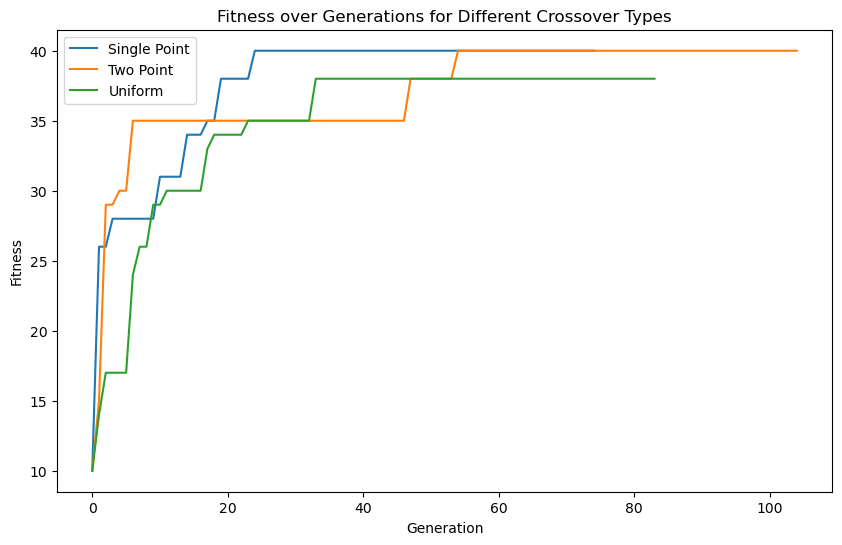

In [11]:
def run_ga_and_plot_fitness(crossover_functions, crossover_names):
    fitness_history = {name: [] for name in crossover_names}
    
    for crossover_func, name in zip(crossover_functions, crossover_names):
        ga_instance = pygad.GA(
            num_generations=num_generations,
            num_parents_mating=num_parents_mating,
            fitness_func=create_fitness_function_basic(fitnes_penalty),
            sol_per_pop=population_size,
            num_genes=num_reviewers * num_papers,
            initial_population=initial_pop,
            crossover_type=crossover_func,
            mutation_type="random",
            mutation_probability=0.05,
            gene_type=int,
            gene_space=[0, 1],
            stop_criteria="saturate_50",
            parent_selection_type="tournament"
        )
        
        ga_instance.run()
        fitness_history[name] = ga_instance.best_solutions_fitness
        
    # Plot the fitness history
    plt.figure(figsize=(10, 6))
    for name in mutation_names:
        plt.plot(fitness_history[name], label=name)
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.title("Fitness over Generations for Different Crossover Types")
    plt.legend()
    plt.show()


mutation_funcs = ["single_point", "two_points", "uniform"]	
mutation_names = ["Single Point", "Two Point", "Uniform"]

run_ga_and_plot_fitness(mutation_funcs, mutation_names)

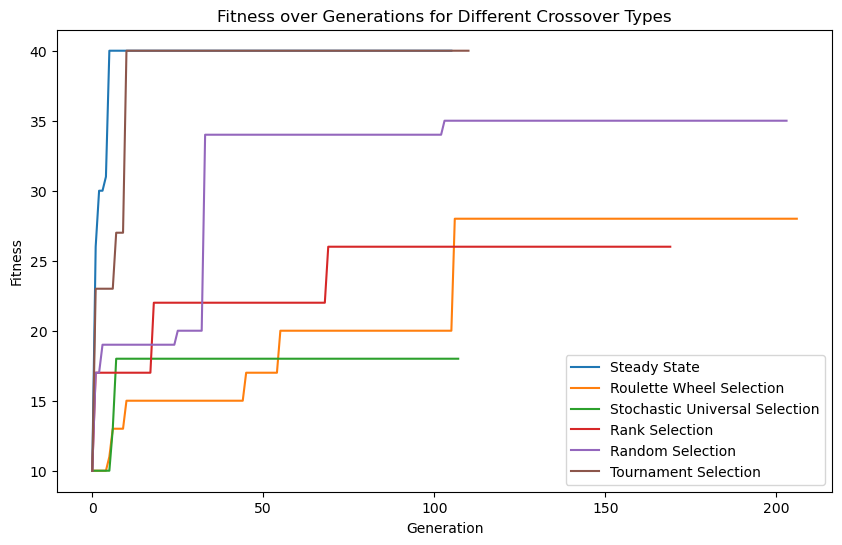

In [22]:

def run_ga_and_plot_fitness(parents_selection, parents_selection_names):
    fitness_history = {name: [] for name in parents_selection_names}
    
    for crossover_func, name in zip(parents_selection, parents_selection_names):
        ga_instance = pygad.GA(
            num_generations=num_generations,
            num_parents_mating=num_parents_mating,
            fitness_func=create_fitness_function_basic(fitnes_penalty),
            sol_per_pop=population_size,
            num_genes=num_reviewers * num_papers,
            initial_population=initial_pop,
            crossover_type="single_point",
            mutation_type="random",
            mutation_probability=0.2,
            gene_type=int,
            gene_space=[0, 1],
            stop_criteria="saturate_100",
            parent_selection_type=crossover_func
        )
        
        ga_instance.run()
        fitness_history[name] = ga_instance.best_solutions_fitness
        
    # Plot the fitness history
    plt.figure(figsize=(10, 6))
    for name in mutation_names:
        plt.plot(fitness_history[name], label=name)
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.title("Fitness over Generations for Different Crossover Types")
    plt.legend()
    plt.show()


mutation_funcs = ["sss", "rws", "sus","rank","random","tournament"]	
mutation_names = ["Steady State", "Roulette Wheel Selection", "Stochastic Universal Selection", "Rank Selection", "Random Selection", "Tournament Selection"]
    
run_ga_and_plot_fitness(mutation_funcs, mutation_names)

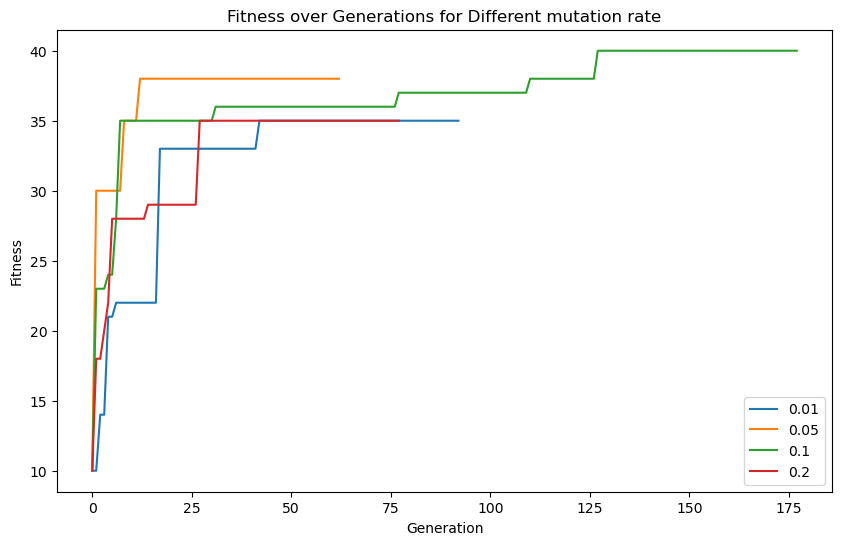

In [20]:
def run_ga_and_plot_fitness(crossover_functions, crossover_names):
    fitness_history = {name: [] for name in crossover_names}
    
    for crossover_func, name in zip(crossover_functions, crossover_names):
        ga_instance = pygad.GA(
            num_generations=num_generations,
            num_parents_mating=num_parents_mating,
            fitness_func=create_fitness_function_basic(fitnes_penalty),
            sol_per_pop=population_size,
            num_genes=num_reviewers * num_papers,
            initial_population=initial_pop,
            crossover_type="single_point",
            mutation_type="random",
            mutation_probability=crossover_func,
            gene_type=int,
            gene_space=[0, 1],
            stop_criteria="saturate_50",
            parent_selection_type="tournament"
        )
        
        ga_instance.run()
        fitness_history[name] = ga_instance.best_solutions_fitness
        
    # Plot the fitness history
    plt.figure(figsize=(10, 6))
    for name in mutation_names:
        plt.plot(fitness_history[name], label=name)
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.title("Fitness over Generations for Different mutation rate")
    plt.legend()
    plt.show()


mutation_funcs = [0.01,0.05,0.1,0.2]	
mutation_names = ["0.01", "0.05", "0.1", "0.2"]

run_ga_and_plot_fitness(mutation_funcs, mutation_names)

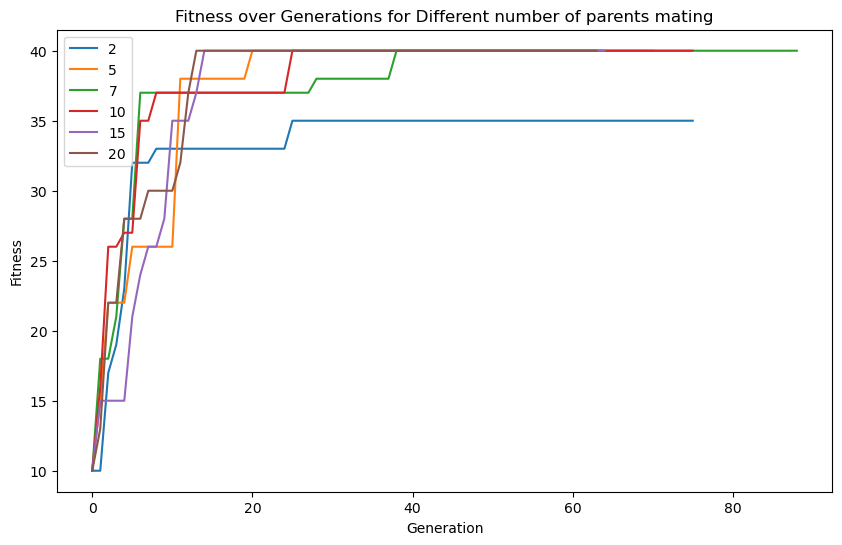

In [13]:
def run_ga_and_plot_fitness(crossover_functions, crossover_names):
    fitness_history = {name: [] for name in crossover_names}
    
    for crossover_func, name in zip(crossover_functions, crossover_names):
        ga_instance = pygad.GA(
            num_generations=num_generations,
            num_parents_mating=crossover_func,
            fitness_func=create_fitness_function_basic(fitnes_penalty),
            sol_per_pop=population_size,
            num_genes=num_reviewers * num_papers,
            initial_population=initial_pop,
            crossover_type="single_point",
            mutation_type="random",
            mutation_probability=0.05,
            gene_type=int,
            gene_space=[0, 1],
            stop_criteria="saturate_50",
            parent_selection_type="tournament"
        )
        
        ga_instance.run()
        fitness_history[name] = ga_instance.best_solutions_fitness
        
    # Plot the fitness history
    plt.figure(figsize=(10, 6))
    for name in mutation_names:
        plt.plot(fitness_history[name], label=name)
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.title("Fitness over Generations for Different number of parents mating")
    plt.legend()
    plt.show()


mutation_funcs = [2,5,7,10,15,20]
mutation_names = ["2", "5", "7", "10", "15", "20"]

run_ga_and_plot_fitness(mutation_funcs, mutation_names)

#### After evaluation we have concluded that the best parameters for the normal genetic algorithm are:
- Number of parents mating: 15, 20
- Mutation rate: 0.05, 0.1
- Parent selection type: tournament, Steady State
- Crossover type: uniform, single_point
- Mutation type: random, Scramble

This will set a starting point for our development of custom mutation and crossover functions

<h2> Task 2 - Crossover and Mutation (30%) </h2>
<h3> 
- Modify the crossover and mutation functions to ensure the generation of valid assignments. <div>
- Consider the structure and constraints of the assignment problem during mutation and crossover. <div>
- Utilize existing genetic algorithm libraries, such as PyGAD, and
adapt them to suit this problem. <div>


<h3> function to check valid solution:


In [ ]:

def solution_is_valid(solution,get_sum=True,print_values=False,return_coorect=False, return_matrix=False):
    solution = solution.flatten()
    penalty_authorship = 0
    penalty_min_reviews = 0
    penalty_max_reviews = 0
    penalty_reviewer_capacity = 0
    penalty_friends = 0
    penalty_authorship = np.sum(solution * A.flatten())
    reshaped_sol = solution.reshape((num_reviewers, num_papers))
    per_reviewer = np.sum(reshaped_sol, axis=1)
    per_paper = np.sum(reshaped_sol, axis=0)
    penalty_min_reviews = np.sum(per_paper < min_reviews_per_paper)
    penalty_max_reviews = np.sum(per_paper > max_reviews_per_paper)
    penalty_reviewer_capacity = np.sum(per_reviewer > reviewer_capacity)
    co_review_matrix = np.dot(reshaped_sol, reshaped_sol.T)
    friend_review_counts = F * co_review_matrix
    penalty_friends = np.sum(friend_review_counts) // 2
    authored_papers_by_friends = np.dot(F, A)
    penalty_matrix = reshaped_sol * authored_papers_by_friends
   # penalty_friends += np.sum(penalty_matrix)

    if print_values:
        print("penalty_authorship: ", penalty_authorship)
        print("penalty_min_reviews: ", penalty_min_reviews)
        print("penalty_max_reviews: ", penalty_max_reviews)
        print("penalty_reviewer_capacity: ", penalty_reviewer_capacity)
        print("penalty_friends: ", penalty_friends)
        print("Sum: ", penalty_authorship + penalty_min_reviews + penalty_max_reviews + penalty_reviewer_capacity + penalty_friends)
    if return_coorect:
        vector = np.array([penalty_authorship, penalty_min_reviews, penalty_max_reviews, penalty_reviewer_capacity, penalty_friends])
        return np.where(vector > 1, 1, 0)
    if return_matrix:
        sol = (penalty_authorship, penalty_min_reviews, penalty_max_reviews, penalty_reviewer_capacity, penalty_friends)
        return np.array(sol)
    if (not get_sum):
        return (penalty_authorship, penalty_min_reviews, penalty_max_reviews, penalty_reviewer_capacity, penalty_friends)
    else:
        return (penalty_authorship + penalty_min_reviews + penalty_max_reviews + penalty_reviewer_capacity + penalty_friends)
    


In [23]:
def custom__single_point_mutation(offspring, ga_instance):
    number_tries = 10
    #we do one mutation 
    for idx in range(offspring.shape[0]):
        initial_vector_constrains = solution_is_valid(offspring[idx], get_sum=False, print_values=False, return_matrix=True)
        constraint_vector = np.array([1 if val == 0 else 0 for val in initial_vector_constrains])
        
        number_mutations = offspring.shape[1] 
        number_tries = 10
        while number_tries > 0:
            gene_idx = np.random.randint(0, offspring.shape[1])
            offspring[idx, gene_idx] = 1 - offspring[idx, gene_idx]
            
            new_constraint_vector = solution_is_valid(offspring[idx], get_sum=False, print_values=False, return_matrix=True)
            if np.all(new_constraint_vector[constraint_vector == 1] == 0):
                number_tries -= 1
            else:
                # If not, revert the mutation
                offspring[idx, gene_idx] = 1 - offspring[idx, gene_idx]
                number_tries -= 1
    if(number_tries != 0):
        print("Mutation failed",number_mutations," times",number_tries)
    return offspring


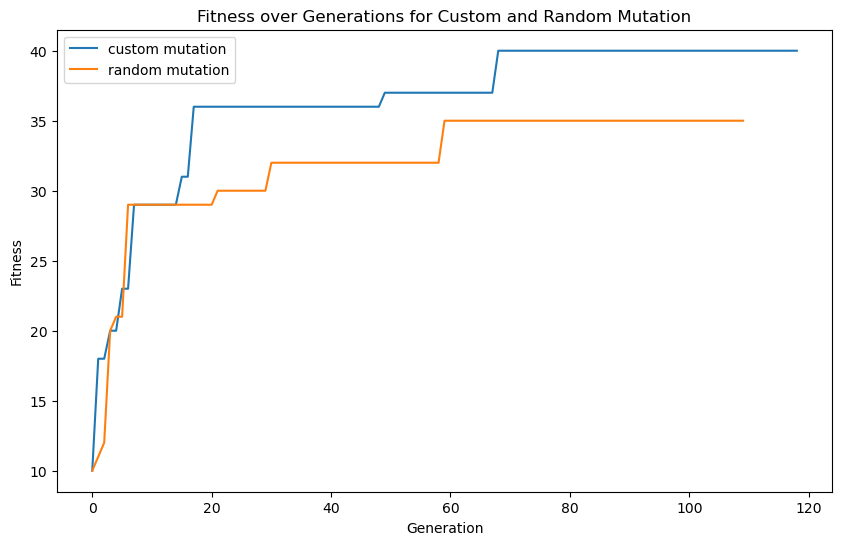

In [30]:


ga_instance_c= pygad.GA(
    num_generations=num_generations,
    num_parents_mating=20,
    fitness_func=create_fitness_function_basic(fitnes_penalty),
    sol_per_pop=population_size,
    num_genes=num_reviewers * num_papers,
    initial_population=initial_pop,
    crossover_type="single_point",
    mutation_type=custom__single_point_mutation,
    mutation_probability=0.20,
    gene_type=int,
    gene_space=[0, 1],
    stop_criteria="saturate_50",
    parent_selection_type="tournament"
)
ga_instance = pygad.GA(
    num_generations=num_generations,
    num_parents_mating=20,
    fitness_func=create_fitness_function_basic(fitnes_penalty),
    sol_per_pop=population_size,
    num_genes=num_reviewers * num_papers,
    initial_population=initial_pop,
    crossover_type="single_point",
    mutation_type="random",
    mutation_probability=0.20,
    gene_type=int,
    gene_space=[0, 1],
    stop_criteria="saturate_50",
    parent_selection_type="tournament"
)

ga_instance_c.run()
ga_instance.run()

# Collect fitness history
fitness_history = {}
fitness_history[0] = ga_instance_c.best_solutions_fitness
fitness_history[1] = ga_instance.best_solutions_fitness

# Plot the fitness history
plt.figure(figsize=(10, 6))
for i in range(2):
    plt.plot(fitness_history[i], label="custom mutation" if i == 0 else "random mutation")

plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("Fitness over Generations for Custom and Random Mutation")
plt.legend()
plt.show()

In [33]:
def custom_crossover_funct(parents, offspring_size, ga_instance):
    offspring = []
    idx = 0
    
    while len(offspring) != offspring_size[0]:
        number_tries = 5
        
        parent1 = parents[idx % parents.shape[0], :].copy()
        parent2 = parents[(idx + 1) % parents.shape[0], :].copy()
        vect_1 = solution_is_valid(parent1, get_sum=False, print_values=False, return_matrix=True)
        vect_2 = solution_is_valid(parent2, get_sum=False, print_values=False, return_matrix=True)
        best = vect_1
        if np.sum(vect_1) > np.sum(vect_2):
            best = vect_2 
        while(number_tries > 0):
            random_split_point = np.random.choice(range(offspring_size[1]))
            parent1[random_split_point:] = parent2[random_split_point:]
            new_constraint_vector = solution_is_valid(parent1, get_sum=False, print_values=False, return_matrix=True)
            constraint_vector = np.array([1 if val == 0 else 0 for val in best])
            if np.all(new_constraint_vector[constraint_vector == 1] == 0):
                offspring.append(parent1)
                number_tries = 0
            number_tries -= 1
            if number_tries == 0:
                offspring.append(parent1)
        idx += 1

    return np.array(offspring)
    

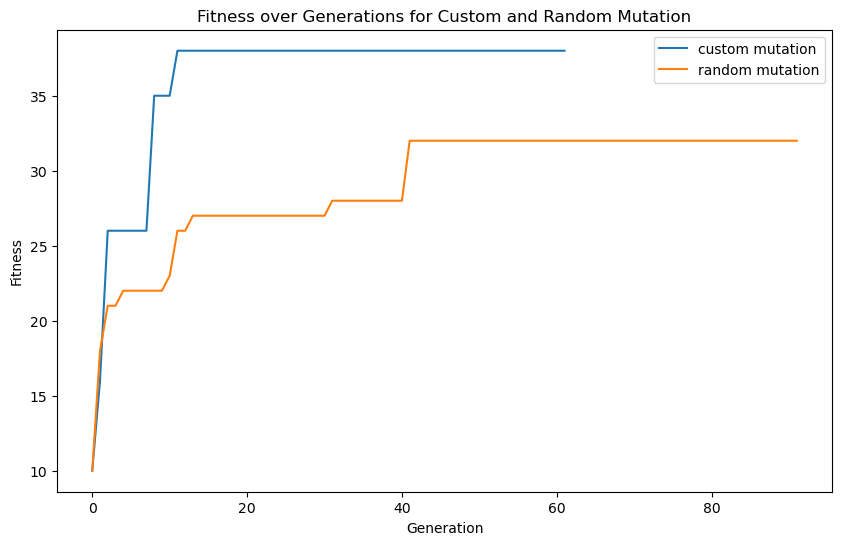

In [34]:


ga_instance_c= pygad.GA(
    num_generations=num_generations,
    num_parents_mating=20,
    fitness_func=create_fitness_function_basic(fitnes_penalty),
    sol_per_pop=population_size,
    num_genes=num_reviewers * num_papers,
    initial_population=initial_pop,
    crossover_type=custom_crossover_funct,
    mutation_type=custom__single_point_mutation,
    mutation_probability=0.20,
    gene_type=int,
    gene_space=[0, 1],
    stop_criteria="saturate_50",
    parent_selection_type="tournament"
)
ga_instance = pygad.GA(
    num_generations=num_generations,
    num_parents_mating=20,
    fitness_func=create_fitness_function_basic(fitnes_penalty),
    sol_per_pop=population_size,
    num_genes=num_reviewers * num_papers,
    initial_population=initial_pop,
    crossover_type="single_point",
    mutation_type="random",
    mutation_probability=0.20,
    gene_type=int,
    gene_space=[0, 1],
    stop_criteria="saturate_50",
    parent_selection_type="tournament"
)

ga_instance_c.run()
ga_instance.run()

# Collect fitness history
fitness_history = {}
fitness_history[0] = ga_instance_c.best_solutions_fitness
fitness_history[1] = ga_instance.best_solutions_fitness

# Plot the fitness history
plt.figure(figsize=(10, 6))
for i in range(2):
    plt.plot(fitness_history[i], label="custom mutation" if i == 0 else "random mutation")

plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("Fitness over Generations for Custom and Random Mutation")
plt.legend()
plt.show()

<h2> Task 3 - Complexity and Diversity </h2>
